In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import VeraRubin as vr
import numpy as np

In [3]:
# Opening the FITS file
stamp_paths = ['stamp/test.fits']

stamps_data = vr.load_exposures(stamp_paths)

In [4]:
# showing the data
print('----> ', stamps_data[0]['type'])

data_stamp = stamps_data[0]['data']
hdr_stamp = stamps_data[0]['header'] 
mask = stamps_data[0]['mask']

---->  fits


### Testing cut/extend with fits file

In [5]:
# Making a referential point
center_coord = (np.array(data_stamp.shape)/2).astype(int)

radius_pixels = 60
cutoutfits, cutout_hdrfits = vr.cutout_fits(data_stamp, hdr_stamp, center_coord, radius_pixels, info=True, ext=0)

print()
radius_pixels = 120 
extoutfits, extout_hdrfits = vr.cutout_fits(data_stamp, hdr_stamp, center_coord, radius_pixels, info=True, ext=0)

Original shape: (148, 148)
Cutout shape: (120, 120)
Center in original (px): (np.int64(74), np.int64(74))
BBox: x[14:134], y[14:134]
Intersection source region: (14, 134, 14, 134)
Intersection destination region: (0, 120, 0, 120)

Original shape: (148, 148)
Cutout shape: (240, 240)
Center in original (px): (np.int64(74), np.int64(74))
BBox: x[-46:194], y[-46:194]
Intersection source region: (0, 148, 0, 148)
Intersection destination region: (46, 194, 46, 194)


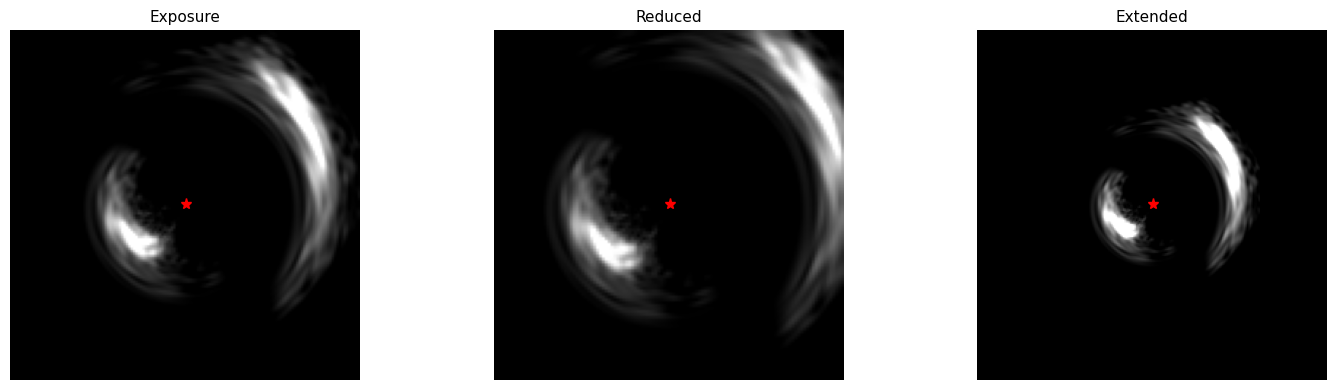

In [15]:
# ploting
exposure_ref = vr.fits_to_exposure(data_stamp, hdr_stamp) # Converting to exposure
exposures = [exposure_ref,
             vr.fits_to_exposure(cutoutfits, cutout_hdrfits), # Converting to exposure
             vr.fits_to_exposure(extoutfits, extout_hdrfits) # Converting to exposure
            ]

center_coord = (np.array(data_stamp.shape)/2).astype(int)
center_coord = exposure_ref.getWcs().pixelToSky(center_coord[0], center_coord[1])

vr.plot_exposures_full(
        exposures,
        center_coord=center_coord,
        exposures_scale='percentile',
        titles=['Exposure', 'Reduced', 'Extended'],
        axeslabels=['pixel', 'pixel'])

### Roting the exposure and saving with the same size

In [16]:
angle_list = [0, 30, 180, 360] # [0, 30, 45, 90]  # [0, 0, 0, 0, 0, 0]

rotate_stamps_list = []
for rotation_angle in angle_list:
    data_temp, hdr_temp = vr.apply_correction_from_exposureF(
        data_stamp, hdr_stamp, rotation_angle,
        warping_kernel='lanczos4',
        keep_size=False,
        update_wcs=True
    )

    # Converting to exposure
    temp = vr.fits_to_exposure(data_temp, hdr_temp)
    
    rotate_stamps_list.append(temp)

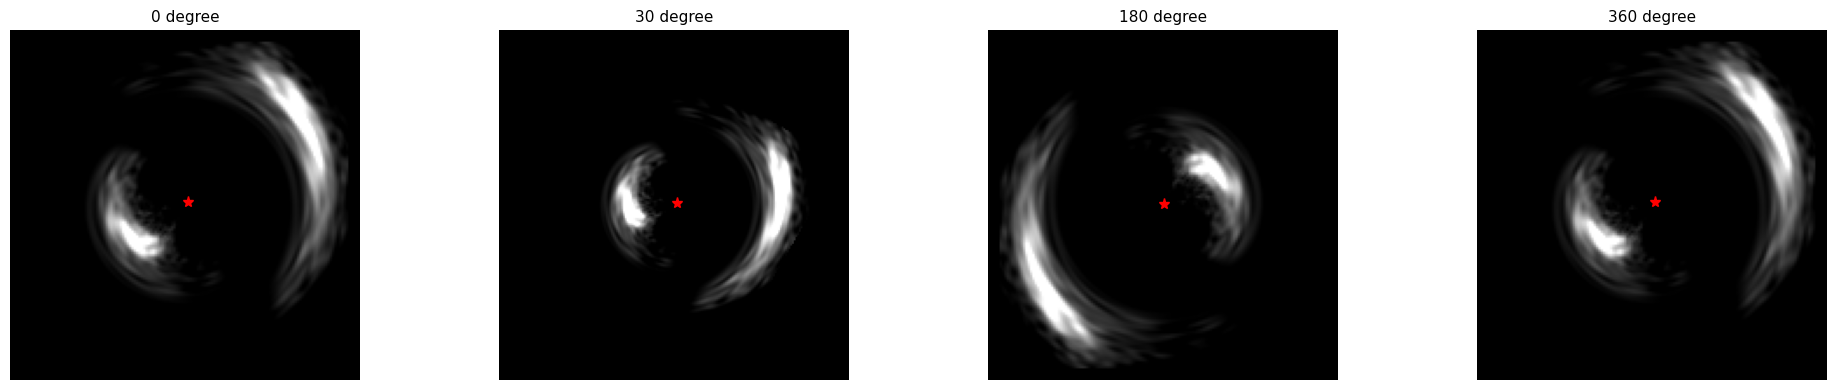

In [17]:
center_coord = exposure_ref.getWcs().pixelToSky(center_coord[0], center_coord[1])

# Making a referential point
inX, inY = exposure_ref.image.array.shape[0]/2, exposure_ref.image.array.shape[0]/2
center_coord = exposure_ref.getWcs().pixelToSky(inX, inY)

vr.plot_exposures_full(
        rotate_stamps_list,
        center_coord=center_coord,
        exposures_scale='percentile',
        titles=[str(i) + ' degree' for i in angle_list],
        axeslabels=['pixel', 'pixel'])

Notice that in general, every stamp has a different size. Fixing its sizes:

In [18]:
radius = 120
cut_rotate_stamps_list = []
for rot_stamp in rotate_stamps_list:
    cutout_temp = vr.cutout_exposure(rot_stamp, center_coord, radius, info=False)
    cut_rotate_stamps_list.append(cutout_temp)

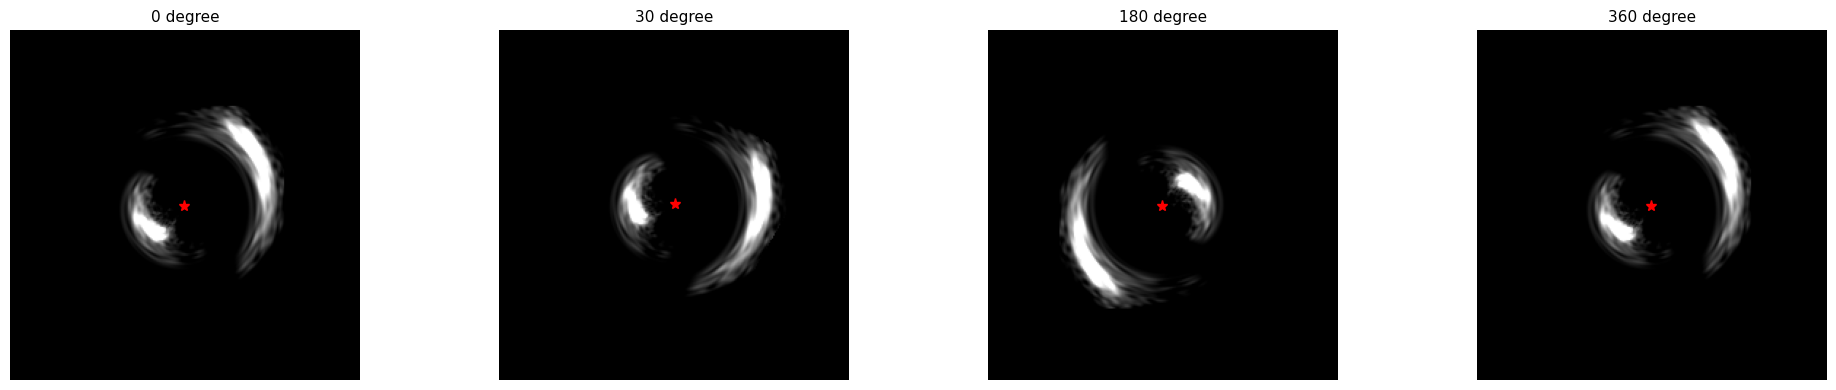

In [19]:
vr.plot_exposures_full(
        cut_rotate_stamps_list,
        center_coord=center_coord,
        exposures_scale='percentile',
        titles=[str(i) + ' degree' for i in angle_list],
        axeslabels=['pixel', 'pixel'])

--> lanczos4 3.8025252e-07


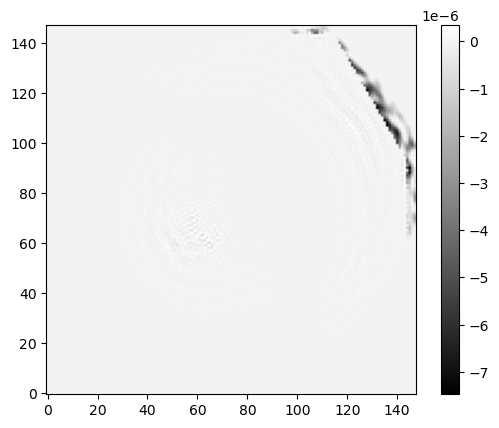

--> lanczos3 2.820126e-07


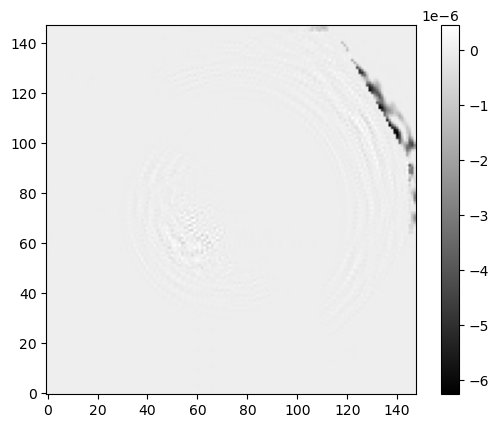

--> bilinear 3.963532e-07


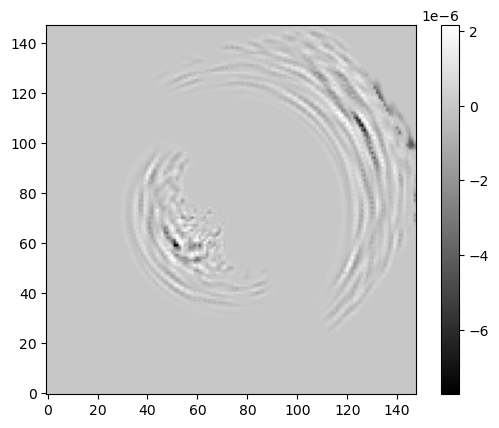

In [20]:
# checks rotation procedure

# Test rotation kernel
A = data_stamp.copy()

for k in ['lanczos4', 'lanczos3', 'bilinear']: #, 'bilinear', 'lanczos3'
    B, hdrB = vr.apply_correction_from_exposureF(A, hdr_stamp, 30, warping_kernel=k, keep_size=True, update_wcs=True)
    A2, _ = vr.apply_correction_from_exposureF(B, hdrB, -30, warping_kernel=k, keep_size=True, update_wcs=False)
    diff = A2 - A
    print('-->', k, np.sqrt(np.mean(diff**2)))
    plt.imshow(diff, origin='lower', cmap='gray', vmin=np.nanpercentile(diff, 0.01),
                  vmax=np.nanpercentile(diff, 99.9))

    #plt.xlim(0, 150)
    #plt.ylim(0, 150)
    plt.colorbar()
    plt.show()

--> bilinear 2.320606e-06
30


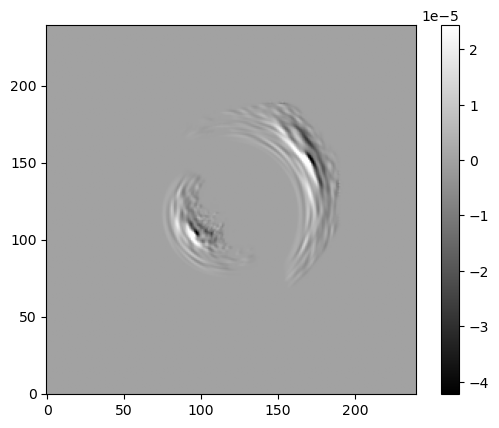

--> bilinear 5.1928364e-06
180


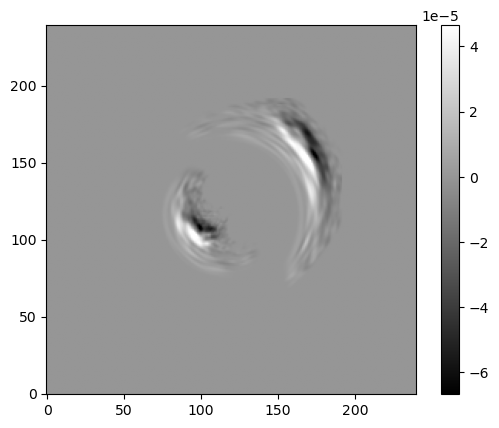

--> bilinear 1.2391789e-12
360


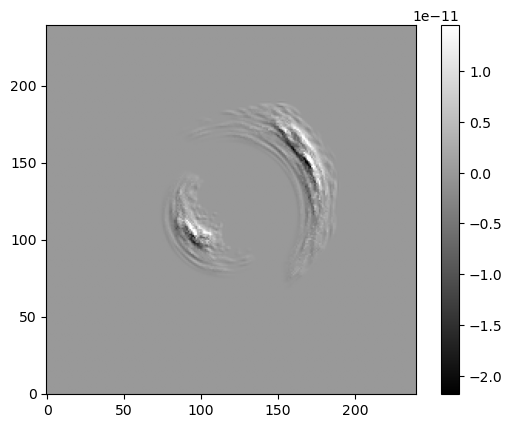

In [21]:
# Test rotation kernel
A, _ = vr.exposure_to_fits_datahdr(cut_rotate_stamps_list[0])

for ind, r_stamp_exp in enumerate(cut_rotate_stamps_list[1:], start=1): #, 'bilinear'
    data, hdr = vr.exposure_to_fits_datahdr(r_stamp_exp)
    angle = angle_list[ind]
    B, _ = vr.apply_correction_from_exposureF(data, hdr, -angle, warping_kernel='lanczos4',
                                              keep_size=True, update_wcs=False)
    diff = A - B
    print('-->', k, np.sqrt(np.mean(diff**2)))
    print(angle)
    plt.imshow(diff, origin='lower', cmap='gray', vmin=np.nanpercentile(diff, 0.01),
                  vmax=np.nanpercentile(diff, 99.9))

    #plt.xlim(0, 150)
    #plt.ylim(0, 150)
    plt.colorbar()
    plt.show()

In [22]:
# check the rotation
for i in range(1, len(angle_list)):
    averpix = vr.validate_rotation(cut_rotate_stamps_list[0].getImage().getArray(),
                  cut_rotate_stamps_list[i].getImage().getArray(), rotation_angle=angle_list[i], n_points=20)
    print(averpix)

Average pixel intensity error after rotation: 0.000007
7.493645e-06
Average pixel intensity error after rotation: 0.000004
4.049919e-06
Average pixel intensity error after rotation: 0.000000
0.0


### Making a coadd 

[INFO] Starting coaddition of 4 exposures...
Warp 1: 0.000% NaN pixels
Offset (degree): 0.0
Rotation angle (degree): 0.0
→ Total diff: 0.0 Max: 0.0 Min: 0.0


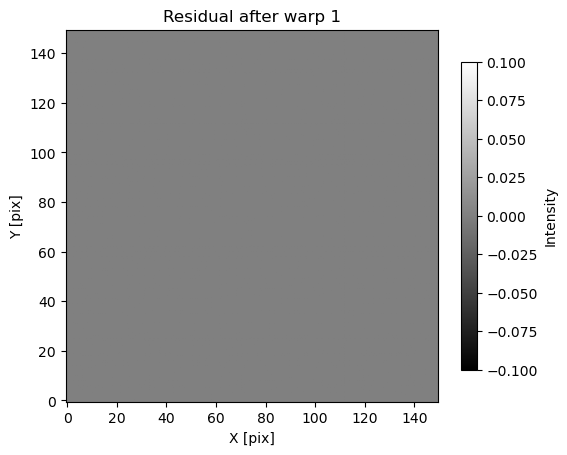

[1/4] exposure coadded.
Warp 2: 0.400% NaN pixels
Offset (degree): 15.450287981967469
Rotation angle (degree): 330.0
→ Total diff: 7.881739e-05 Max: 1.395127e-05 Min: 0.0


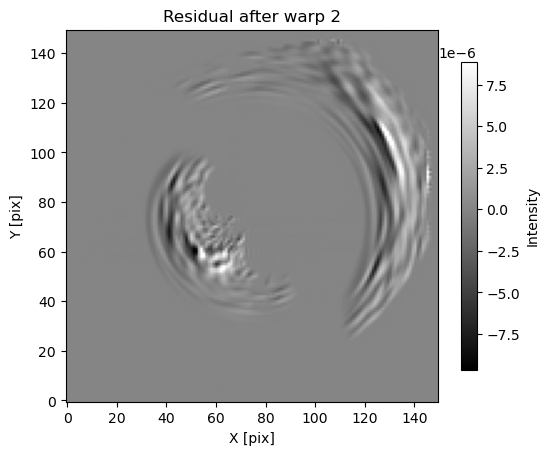

[2/4] exposure coadded.
Warp 3: 9.116% NaN pixels
Offset (degree): 0.30671674320546205
Rotation angle (degree): 180.0
→ Total diff: 0.0 Max: 6.0850616e-05 Min: 0.0


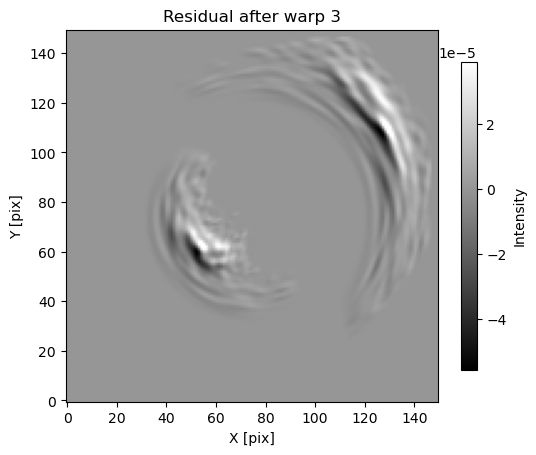

[3/4] exposure coadded.
Warp 4: 0.000% NaN pixels
Offset (degree): 0.0
Rotation angle (degree): 0.0
→ Total diff: 0.0 Max: 0.0 Min: 0.0


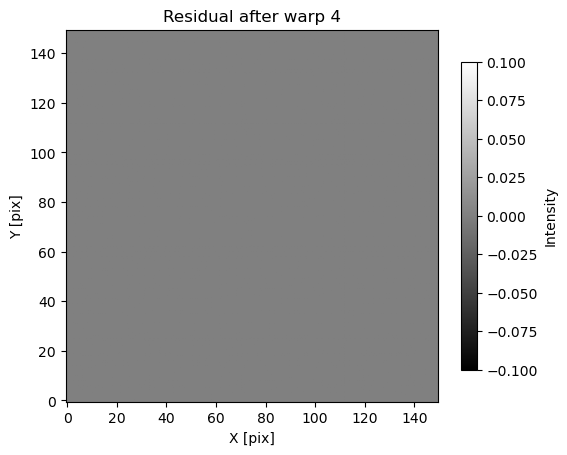

[4/4] exposure coadded.
[INFO] LSST-style coadd saved to ./coadds_stamp_rotation/stamp_rotation_0.fits
[INFO] Coverage map saved to ./coadds_stamp_rotation/coverage_map.fits
Coaddition complete.
Pixels with no coverage: 0 / 22500


In [23]:
coadd_exp_0, coverage_map_0 = vr.coadd_exposures_pipeline(
    rotate_stamps_list, 
    ref_exp=rotate_stamps_list[0],
    warping_kernel="lanczos4",  # "lanczos3"
    save_path="./coadds_stamp_rotation",
    coadd_name=f"stamp_rotation_0.fits",
    info=True,
    plot_debug=True,
    same_check=True
)

[INFO] Starting coaddition of 4 exposures...
→ Total diff: 0.0 Max: 0.0 Min: 0.0


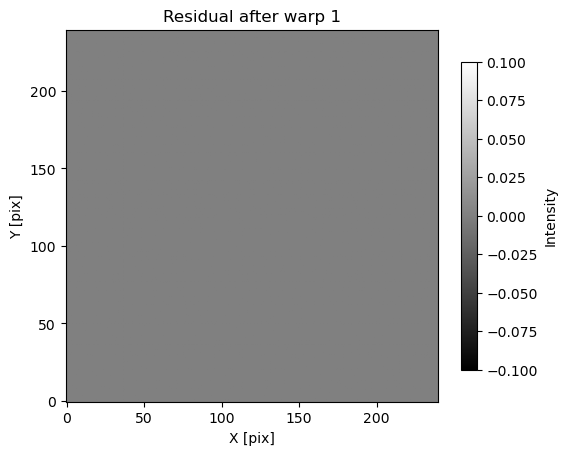

[1/4] exposure coadded.
→ Total diff: 7.881576e-05 Max: 1.395127e-05 Min: 0.0


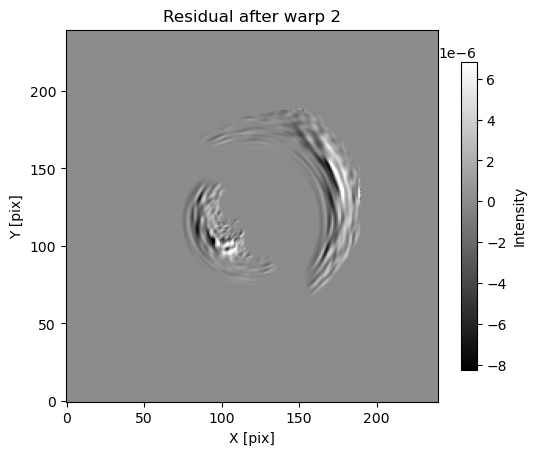

[2/4] exposure coadded.
→ Total diff: 0.0 Max: 6.0850616e-05 Min: 0.0


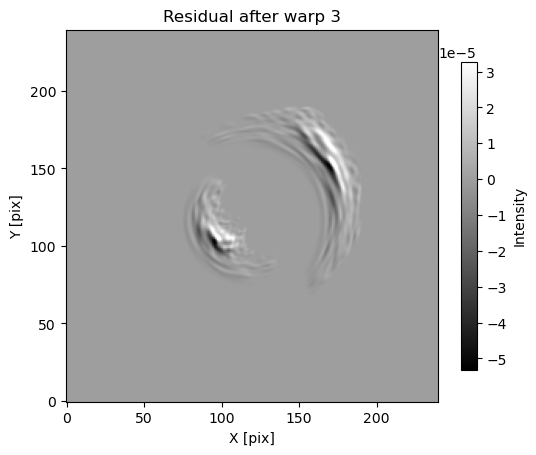

[3/4] exposure coadded.
→ Total diff: 0.0 Max: 0.0 Min: 0.0


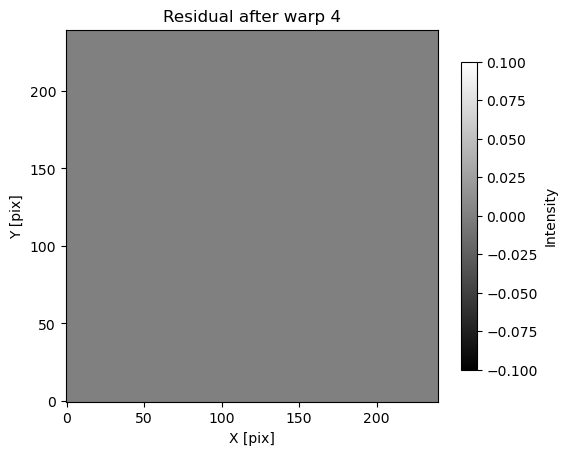

[4/4] exposure coadded.
[INFO] LSST-style coadd saved to ./coadds_stamp_rotation/stamp_rotation.fits
[INFO] Coverage map saved to ./coadds_stamp_rotation/coverage_map.fits
Coaddition complete.
Pixels with no coverage: 16310 / 57600


In [24]:
coadd_exp, coverage_map = vr.coadd_exposures_pipeline(
    cut_rotate_stamps_list, 
    ref_exp=None,
    warping_kernel="lanczos4",  # "lanczos4" "bilinear"
    save_path="./coadds_stamp_rotation",
    coadd_name=f"stamp_rotation.fits",
    plot_debug=True,
    same_check=True)

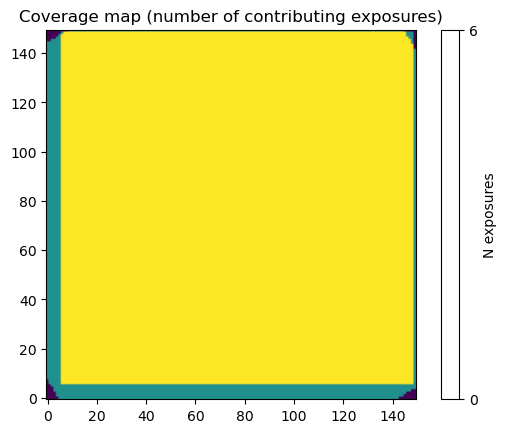

In [25]:
plt.imshow(coverage_map_0, origin='lower', cmap='viridis')
plt.contour(coverage_map_0, levels=[0, 6], colors='white', linewidths=0.8)
plt.title('Coverage map (number of contributing exposures)')
plt.colorbar(label='N exposures')
plt.show()

In [38]:
# Loading the Exposure Coadd
from lsst.afw.image import ExposureF

coadd_exp_0 = ExposureF.readFits(f"./coadds_stamp_rotation/stamp_rotation_0.fits")
coadd_exp = ExposureF.readFits(f"./coadds_stamp_rotation/stamp_rotation.fits")

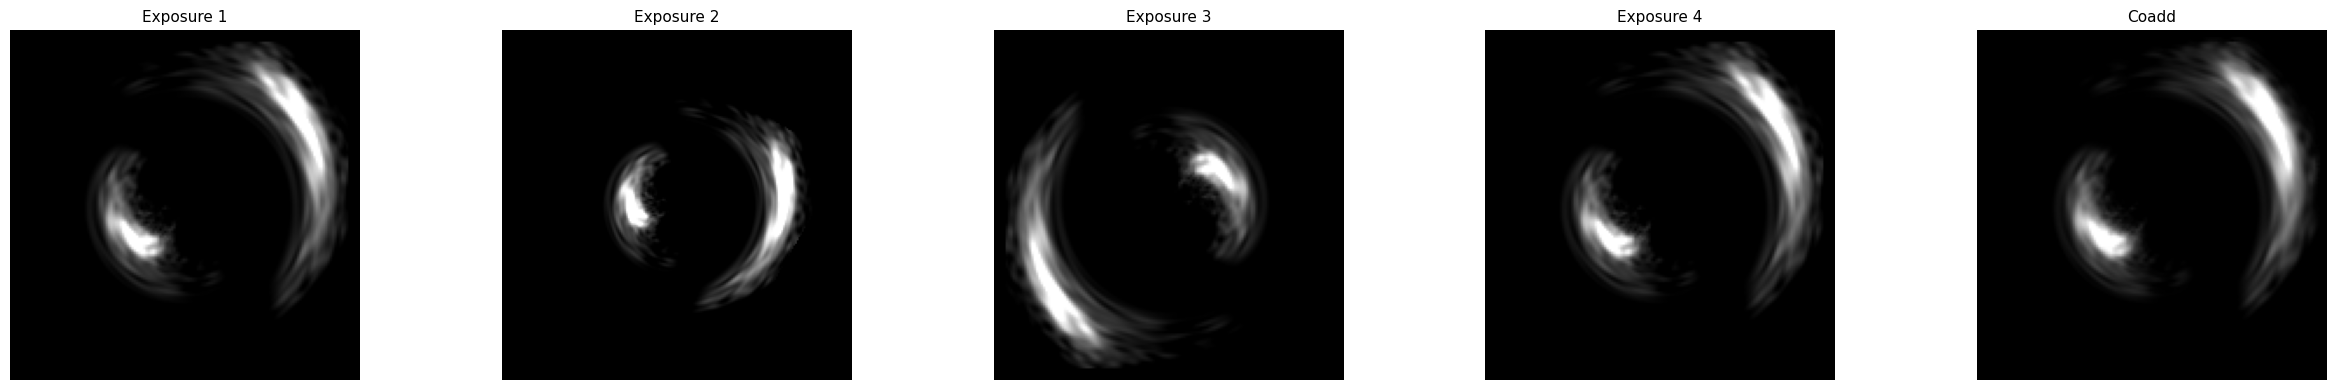

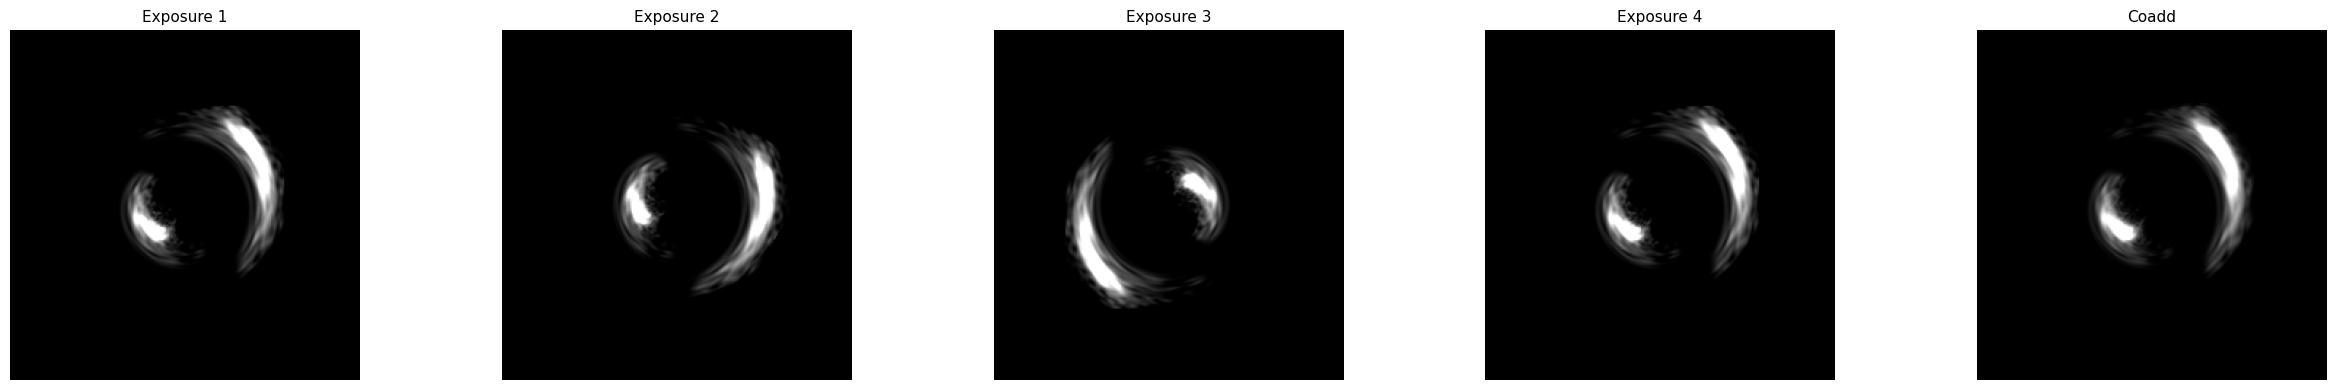

In [40]:
# Visualizing the result 
vr.plot_exposures_full(rotate_stamps_list,
                         coadd_exp_0,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=False,
                         save_path=None)

vr.plot_exposures_full(cut_rotate_stamps_list,
                         coadd_exp,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=False,
                         save_path=None)

[INFO] Converted LSST SkyWcs -> Astropy WCS


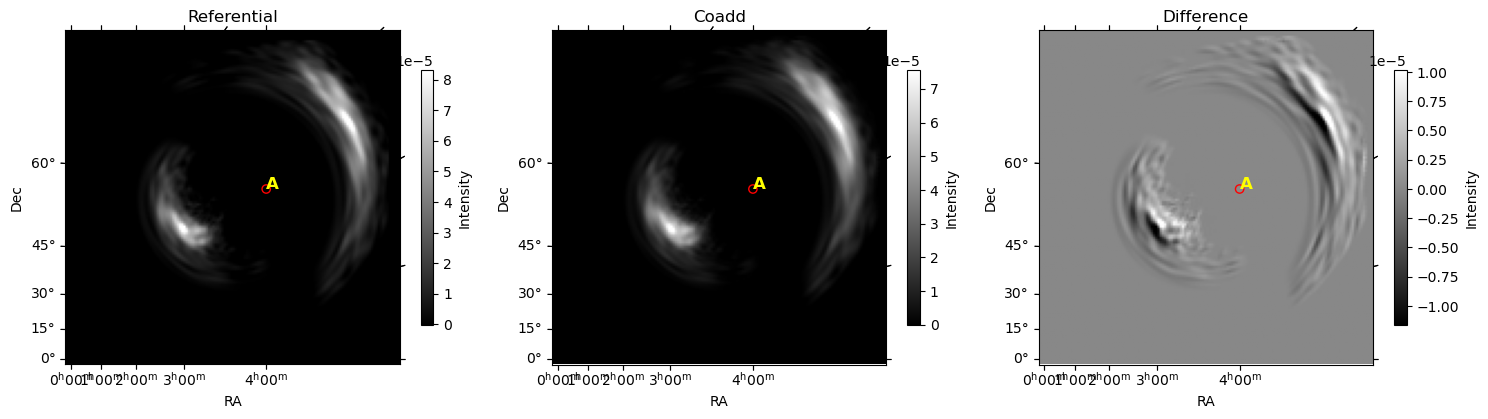

In [41]:
points = [[60, 37]] # no importa
vr.injection_steps(
    rotate_stamps_list[0],
    coadd_exp_0,
    points,
    diference=True,
    cutout_radius_arcsec=None,  # arcsec 
    grid=False, percentiles=[.1, 99.9],
    names=['Referential', 'Coadd', 'Difference'])

[INFO] Converted LSST SkyWcs -> Astropy WCS


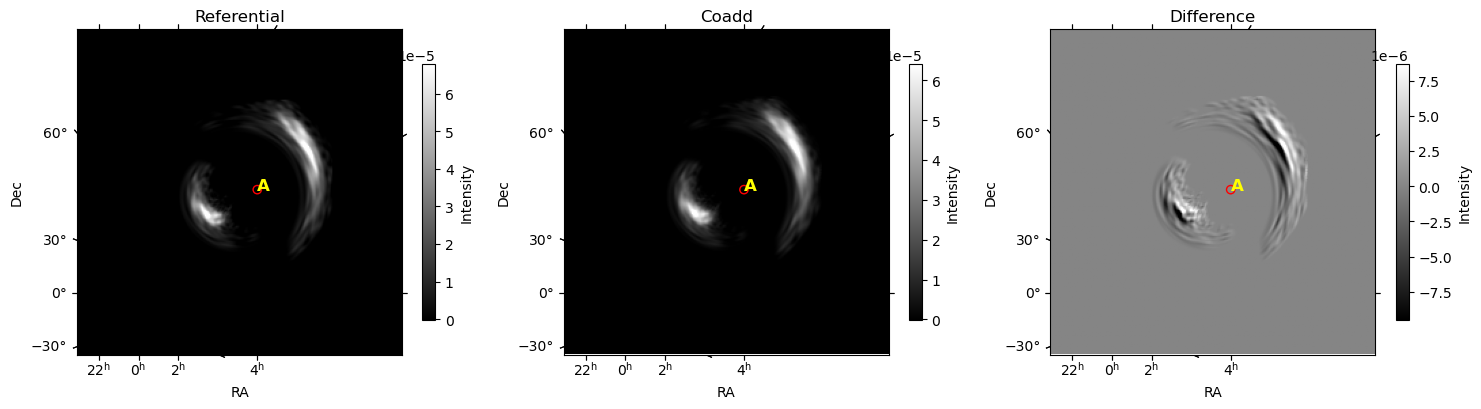

In [42]:
points = [[60, 37]] # no importa
vr.injection_steps(
    cut_rotate_stamps_list[0],
    coadd_exp,
    points,
    diference=True,
    cutout_radius_arcsec=None,  # arcsec 
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

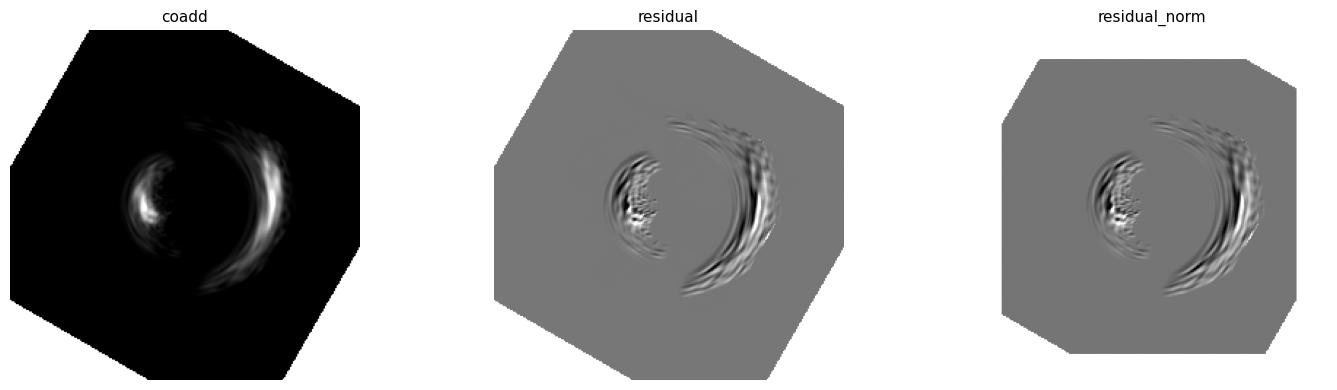

In [49]:
# fast test
warped_exp, residual, residual_norm = vr.leave_one_out_residual(cut_rotate_stamps_list[1],
                                    cut_rotate_stamps_list[0], warping_kernel="lanczos3")

temp = [warped_exp, residual, residual_norm]
vr.plot_exposures_full(temp,
                       center_coord=None,
                       titles=['coadd', 'residual', 'residual_norm'],
                       exposures_scale='percentile',
                       axeslabels=['pixel', 'pixel'],
                       percentiles=[0.1, 99.9])